## Elephant Issue - Bandpass filtering in Theta Band 

Issue found with bandpass filtering using Elephant for theta band (4-8 Hz in rodents). Created test signal to compare scipy bandpass method with Elephant method to see if issue arised from (a) scipy, (b) incorrect data or argument supplied to Elephant, or (c) something else.

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

import neo
from quantities import Hz, mV, sec, ms
from elephant import signal_processing

%matplotlib notebook

/home/julianb/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [26]:
def bandpass(x, lo, hi, fs, order=4):
    nyquist = fs/2.0
    filt = sig.butter(order, [lo/nyquist, hi/nyquist], btype='band', output='sos')
    return sig.sosfiltfilt(filt, x), filt


def angrad2hz(x, fs):
    ''' rad/sec -> cycles/sec (Hz)
    '''
    return x * (fs * 0.5/np.pi)


def plot_sosfilter_response(filter1, fs, worN=2000, xlims=(0,20), xlines=(), norm=False):
    w, h = sig.sosfreqz(filter1, worN=worN)
    if norm:
        plt.semilogx(w, 20*np.log10(np.maximum(np.abs(h), 1e-5)))
        plt.xlabel('Normalised Frequency (rad/sec)')
    else: 
        plt.plot(angrad2hz(w,fs), 20*np.log10(np.maximum(np.abs(h), 1e-5)))
        plt.xlabel('Frequency (Hz)')
    plt.xlim(xlims)
    plt.grid(which='both', axis='both', color='grey')
    for line in xlines:
        plt.axvline(line, color='green') 
    plt.ylabel('Amplitude (dB)')
    plt.title('Filter Response (sos)')

    
def plot_bafilter_response(filter_b, filter_a, fs, worN=2000, xlims=(0,20), xlines=(), norm=False):
    w, h = sig.freqz(filter_b, filter_a, worN=worN)
    if norm:
        plt.semilogx(w, 20*np.log10(np.maximum(np.abs(h), 1e-5)))
        plt.xlabel('Normalised Frequency (rad/sec)')
    else: 
        plt.plot(angrad2hz(w,fs), 20*np.log10(np.maximum(np.abs(h), 1e-5)))
        plt.xlabel('Frequency (Hz)')
    plt.xlim(xlims)
    plt.grid(which='both', axis='both', color='grey')
    for line in xlines:
        plt.axvline(line, color='green') 
    plt.ylabel('Amplitude (dB)')
    plt.title('Filter Response (ba)')

    

### Test Signal

Created test signal concatenating 1 second each of 2 Hz, 6 Hz and 12 Hz noisy sine waves.

In [3]:
def test_sig():
    fs = 5000.0
    t = np.arange(0.0,3.0,1.0/fs)
    s = 0.1*np.random.normal(size=len(t))
    s[0:5000] += np.sin(2.0*np.pi*2.0*t[0:5000])
    s[5000:10000] += np.sin(2.0*np.pi*6.0*t[0:5000])
    s[10000:15000] += np.sin(2.0*np.pi*12.0*t[0:5000])
    return t, s, fs

Create numpy verison:

In [4]:
tt, ss, fss = test_sig()
ss.shape, fss

((15000,), 5000.0)

Create AnalogSignal version:

In [5]:
rec = neo.AnalogSignal(ss, sampling_rate=fss*Hz, units='mV')
rec

AnalogSignal with 1 channels of length 15000; units mV; datatype float64 
sampling rate: 5000.0
time: 0.0 to 3.0

Show plots of each version of signal:

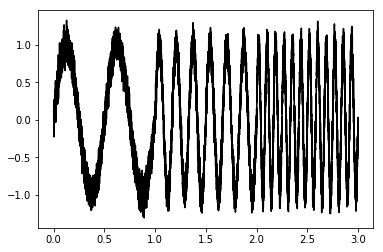

In [6]:
plt.plot(tt, ss, 'k-');

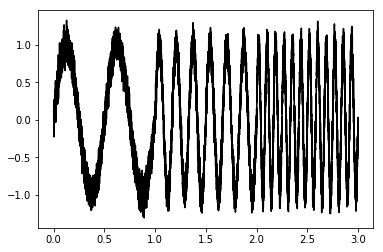

In [7]:
plt.plot(rec.times, rec.magnitude, 'k-');

### scipy bandpass

#### 'sos'

Here use scipy filter 'sos' (second-order sections) output. 

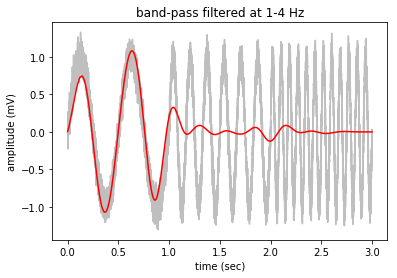

In [8]:
y0, bfilt = bandpass(ss, 1.0, 4.0, fss, order=5)
plt.plot(tt,ss,'k-',alpha=0.25)
plt.plot(tt,y0,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')
plt.title('band-pass filtered at 1-4 Hz');

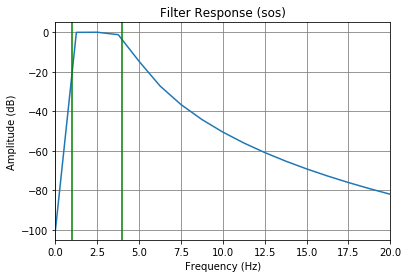

In [9]:
plot_sosfilter_response(bfilt, fss, xlines=(1.0,4.0))

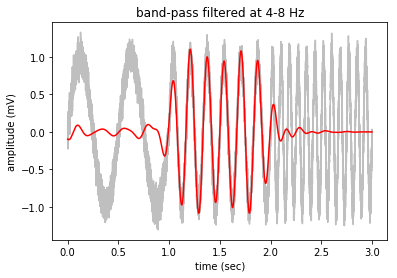

In [10]:
y1, bfilt = bandpass(ss, 4.0, 8.0, fss, order=5)
plt.plot(tt,ss,'k-',alpha=0.25)
plt.plot(tt,y1,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')
plt.title('band-pass filtered at 4-8 Hz');

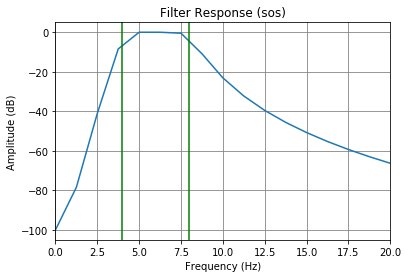

In [11]:
plot_sosfilter_response(bfilt, fss, xlines=(4.0,8.0))

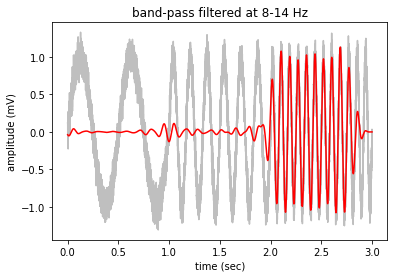

In [14]:
y2, bfilt = bandpass(ss, 8.0, 14.0, fss, order=5)
plt.plot(tt,ss,'k-',alpha=0.25)
plt.plot(tt,y2,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')
plt.title('band-pass filtered at 8-14 Hz');

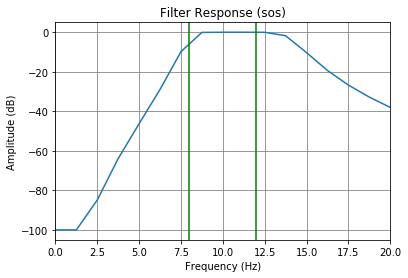

In [15]:
plot_sosfilter_response(bfilt, fss, xlines=(8.0,12.0))

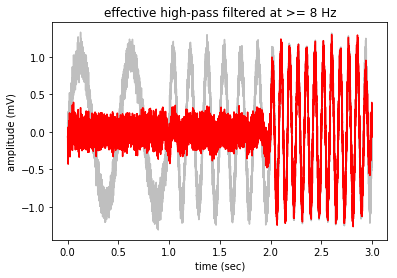

In [16]:
y0, bfilt = bandpass(ss, 8.0, 2499.0, fss, order=5)
plt.plot(tt,ss,'k-',alpha=0.25)
plt.plot(tt,y0,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')
plt.title('effective high-pass filtered at >= 8 Hz');

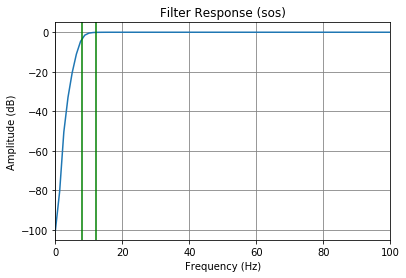

In [17]:
plot_sosfilter_response(bfilt, fss, xlims=(0,100), xlines=(8.0,12.0))

#### 'ba'

Elephant code uses scipy filter numerator/denominator (‘ba’) output. 

(a) Low-Pass Test

Using scipy method for low-pass filtering taken from https://github.com/NeuralEnsemble/elephant/blob/master/elephant/signal_processing.py. This works as expected and similar to 'sos' results. 

In [18]:
Fn = fss/2.0
Wn = 4.0 / Fn
btype = 'lowpass'
b, a = sig.butter(5.0, Wn, btype=btype)
yx = sig.filtfilt(b, a, ss, axis=-1)
Wn, Fn 

(0.0016, 2500.0)

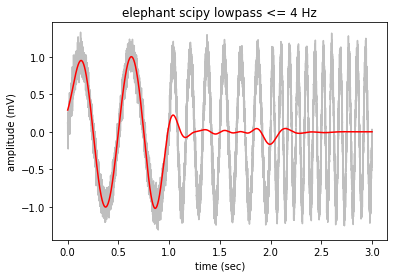

In [19]:
plt.plot(tt,ss,'k-',alpha=0.25)
plt.plot(tt,yx,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')
plt.title('elephant scipy lowpass <= 4 Hz');

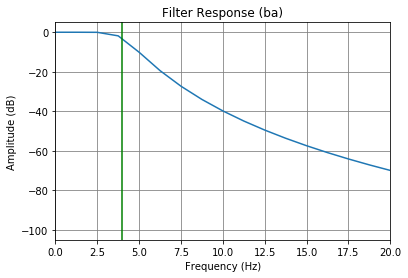

In [29]:
plot_bafilter_response(b, a, fss, xlines=(4.0,))

(b) High-Pass Test

Using scipy method for high-pass filtering taken from https://github.com/NeuralEnsemble/elephant/blob/master/elephant/signal_processing.py. This works as expected similar to 'sos' scipy method.

In [30]:
Fn = fss/2.0
Wn = 8.0 / Fn
btype = 'highpass'
b, a = sig.butter(5.0, Wn, btype=btype)
yx = sig.filtfilt(b, a, ss, axis=-1)
Wn, Fn 

(0.0032, 2500.0)

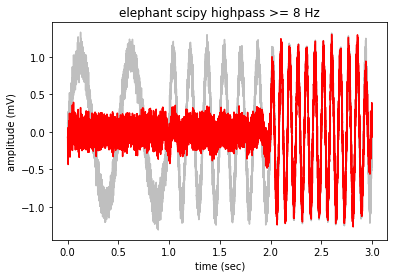

In [31]:
plt.plot(tt,ss,'k-',alpha=0.25)
plt.plot(tt,yx,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')
plt.title('elephant scipy highpass >= 8 Hz');

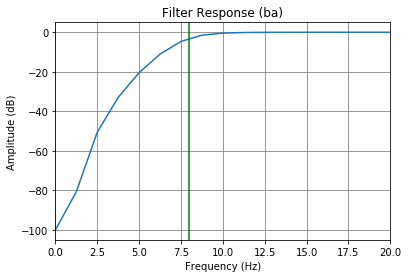

In [32]:
plot_bafilter_response(b, a, fss, xlines=(8.0,))

(c) Band-Pass Test

Using scipy method for band-pass filter taken from https://github.com/NeuralEnsemble/elephant/blob/master/elephant/signal_processing.py. requires condition hpfreq < lpfreq be met for bandpass, so set hpfreq = 4.0 and lpfreq = 8.0:

In [40]:
hpfreq = 4.0
lpfreq = 8.0
Fn = fss/2.0
#Wn = (hpfreq / Fn, lpfreq / Fn)
Wn = (lpfreq / Fn, hpfreq / Fn)
btype = 'bandpass'
b, a = sig.butter(4.0, Wn, btype=btype)
yx = sig.filtfilt(b, a, ss, axis=-1)
Wn, Fn 

((0.0032, 0.0016), 2500.0)

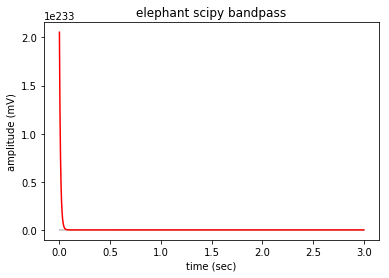

In [41]:
plt.plot(tt,ss,'k-',alpha=0.25)
plt.plot(tt,yx,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')
plt.title('elephant scipy bandpass');

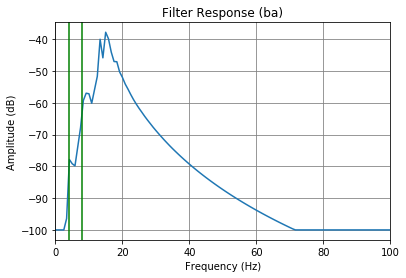

In [42]:
plot_bafilter_response(b, a, fss, xlims=(0,100),xlines=(4.0,8.0), worN=3000)

Could lpfreq, hpfreq arguments be the wrong way round? 

In [43]:
hpfreq = 8.0
lpfreq = 4.0
Fn = fss/2.0
Wn = (lpfreq / Fn, hpfreq / Fn)
btype = 'bandpass'
b, a = sig.butter(4.0, Wn, btype=btype)
yx = sig.filtfilt(b, a, ss, axis=-1)
Wn, Fn 

((0.0016, 0.0032), 2500.0)

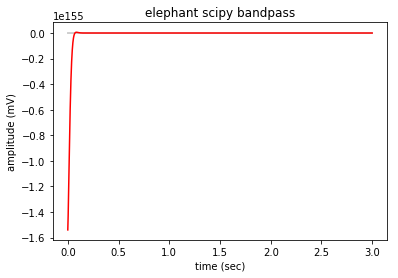

In [44]:
plt.plot(tt,ss,'k-',alpha=0.25)
plt.plot(tt,yx,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')
plt.title('elephant scipy bandpass');

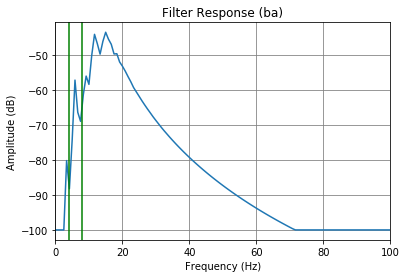

In [45]:
plot_bafilter_response(b, a, fss, xlims=(0,100),xlines=(4.0,8.0), worN=3000)

Could it be filter order? In https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter it states:
```
It’s recommended to use second-order sections format when filtering, to avoid numerical error with transfer function (ba) format
```

Tried 3-rd order and this produces a good response:

In [71]:
hpfreq = 4.0
lpfreq = 8.0
Fn = fss/2.0
Wn = (lpfreq / Fn, hpfreq / Fn)
btype = 'bandpass'
b, a = sig.butter(3, Wn, btype=btype)
Wn, Fn 

((0.0032, 0.0016), 2500.0)

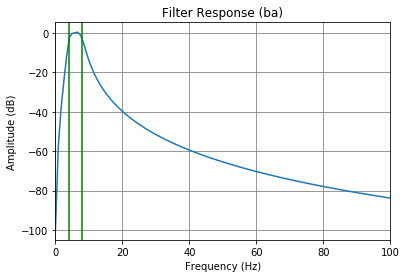

In [72]:
plot_bafilter_response(b, a, fss, xlims=(0,100),xlines=(4.0,8.0), worN=3000)

### Elephant bandpass

Now apply Elephant functions for butterworth filtering to AnalogSignal example.

(a) Low-Pass Test

This works as expected like both 'sos' and 'ba' scipy methods.

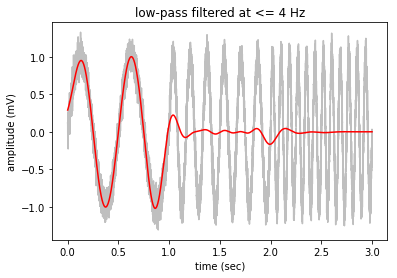

In [64]:
zx = signal_processing.butter(rec, lowpass_freq=4.0*Hz, order=5)
plt.plot(rec.times, rec.magnitude,'k-',alpha=0.25)
plt.plot(zx.times, zx.magnitude,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')
plt.title('low-pass filtered at <= 4 Hz');

(b) High-Pass Test

This works as expected like both 'sos' and 'ba' scipy methods.

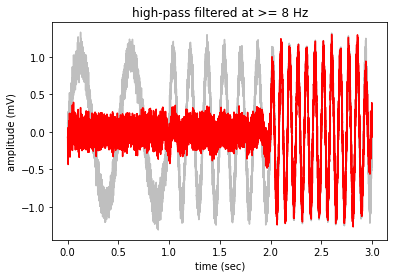

In [65]:
zx = signal_processing.butter(rec, highpass_freq=8.0*Hz, order=5)
plt.plot(rec.times, rec.magnitude,'k-',alpha=0.25)
plt.plot(zx.times, zx.magnitude,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')
plt.title('high-pass filtered at >= 8 Hz');

(c) Band-Pass Test

This does not work as expected - is unlike scipy 'sos' but more like scipy 'ba' although problem does not occur until after 2 sec:

([<matplotlib.lines.Line2D at 0x7f735887e390>],
 Text(0,0.5,'amplitude (mV)'),
 Text(0.5,0,'time (sec)'))

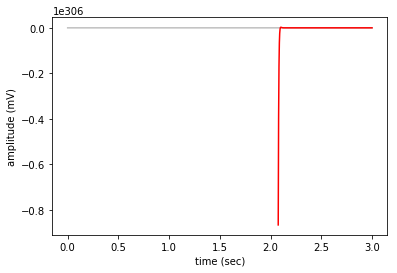

In [66]:
zx = signal_processing.butter(rec, 4.0*Hz, 8.0*Hz, order=5)
plt.plot(rec.times, rec.magnitude,'k-',alpha=0.25)
plt.plot(zx.times, zx.magnitude,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)')

Try a lower order of filter - now it works:

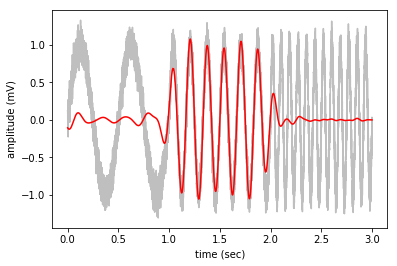

In [73]:
zx = signal_processing.butter(rec, 4.0*Hz, 8.0*Hz, order=3)
plt.plot(rec.times, rec.magnitude,'k-',alpha=0.25)
plt.plot(zx.times, zx.magnitude,'r-'), plt.ylabel('amplitude (mV)'), plt.xlabel('time (sec)');

## Summary

Except for the possibility of having misused functions and lack of expert knowledge, it appears that using scipy 'ba' rather 'sos' filter output for Butterworth filters of order > 3 causes an issue for low-frequency physiological bandpass filtering.